# Normalising Flow

Here we aim to crate a probability distribution over the full parameters in order to cluster.

In [31]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from RealNVP import FlowGMM
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains
from gmm_torch import GaussianMixture

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

# Normalising Flows

The data is inputted from the membership probability section

In [32]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

In [33]:
os.chdir('../cluster_files')
nf_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_99456/3296965813.py:2: DtypeWarning: Columns (12,13,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  nf_data=pd.read_csv('vae_data.csv')


### For now we just dropna instead of dealing with missing values.


So far this is without VRAD error

In [34]:
columns=['ra','dec','parallax','VRAD','pmra','pmdec','bp_g','g_rp',
'ra_error','dec_error','parallax_error','pmra_error','pmdec_error','phot_g_mean_flux'
,'mean_absolute_mag_g_band','bp_rp','prob'
,'parallax_over_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error'
,'phot_g_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','rgeo']


In [35]:
nf_data=nf_data[columns].dropna().reset_index(drop=True)

### The data we are going to use for learning

In [36]:
nf_data

,ra,dec,parallax,VRAD,pmra,pmdec,bp_g,g_rp,ra_error,dec_error,...,bp_rp,prob,parallax_over_error,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,rgeo
0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,0.590866,0.740053,0.062462,0.067593,...,1.330919,4.234866e-102,6.485257,3.267539,12.032261,13.133354,1077.94260,123.194890,223.189440,1942.98157
1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,0.413675,1.044496,0.116390,0.116183,...,1.458172,4.212212e-107,2.363549,2.765547,20.419193,49.949870,511.61658,34.331070,31.203371,6141.48389
2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,0.575531,0.677193,0.061189,0.062669,...,1.252724,5.072590e-05,5.197287,2.765688,8.391808,11.373121,1197.15140,168.404950,228.644740,2671.46338
3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,0.585712,0.756983,0.043225,0.043401,...,1.342695,1.245549e-304,9.769011,3.499412,15.342039,11.257838,1742.58020,168.069720,457.864930,1887.64343
4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,0.529069,0.704749,0.036199,0.036933,...,1.233818,1.793793e-53,8.721489,3.845628,9.647141,11.867042,2172.79220,385.859700,567.223450,2360.14062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,0.790930,0.894377,0.082114,0.090750,...,1.685307,5.522815e-29,0.259058,3.961165,9.669498,12.439868,589.08026,84.467860,179.946430,7084.01074
24571,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.720057,0.885668,0.057465,0.059235,...,1.605724,0.000000e+00,6.669965,3.325069,8.880351,16.920698,1381.98470,193.339860,258.442700,2100.93555
24572,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,1.733685,1.229452,0.071895,0.070749,...,2.963137,3.822749e-07,0.033748,2.894869,6.128861,10.157309,994.19196,68.978790,370.094400,7769.46533
24573,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,0.667429,0.838211,0.090482,0.091330,...,1.505640,4.593510e-18,1.699038,2.571448,9.367966,15.222594,943.16860,101.536180,145.135670,4963.53955


# Error analysis

HR Diagram


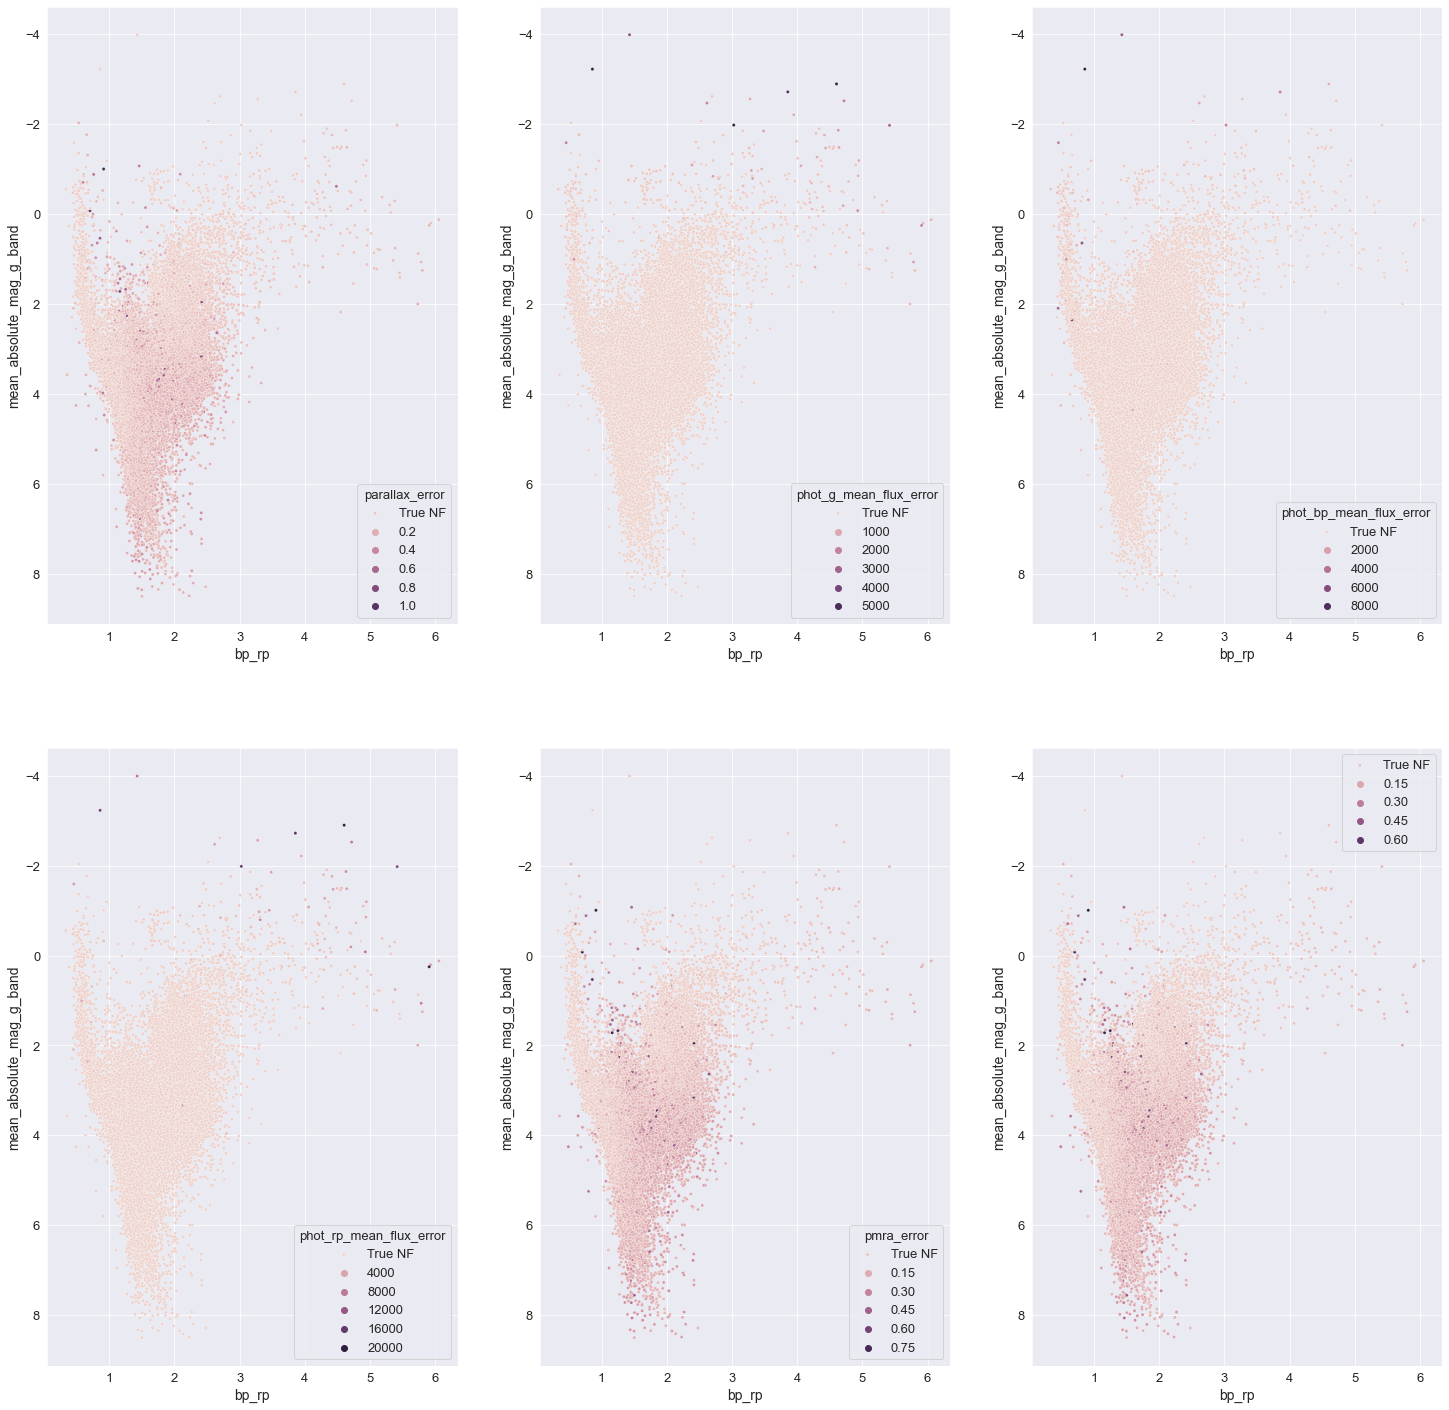

In [37]:
f, axes = plt.subplots(2, 3)
f.set_figheight(25)
f.set_figwidth(25)

scatter=nf_data
sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='parallax_error',ax=axes[0,0],s=10,label='True NF',color='b')

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='phot_g_mean_flux_error',ax=axes[0,1],s=10,label='True NF',color='b')

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='phot_bp_mean_flux_error',ax=axes[0,2],s=10,label='True NF',color='b')

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='phot_rp_mean_flux_error',ax=axes[1,0],s=10,label='True NF',color='b')

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmra_error',ax=axes[1,1],s=10,label='True NF',color='b')

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmdec_error',ax=axes[1,2],s=10,label='True NF',color='b')

#axes.set_xlim(0,2.5)

plt.legend()
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].invert_yaxis()
plt.show()

0.2557253624040972

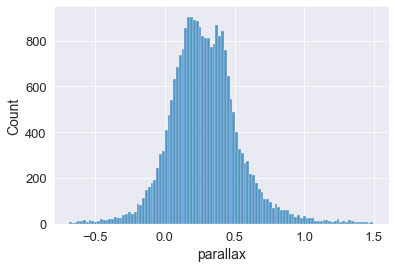

In [38]:
#Parallax
sn.histplot(data=nf_data['parallax'])
nf_data['parallax'].std()


<AxesSubplot:xlabel='parallax_error', ylabel='Count'>

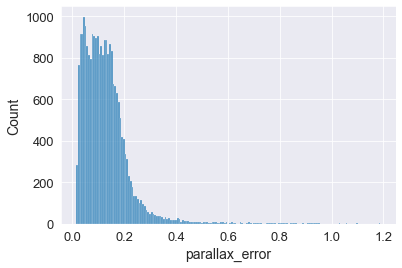

In [39]:
#Parallax
sn.histplot(data=nf_data['parallax_error'])

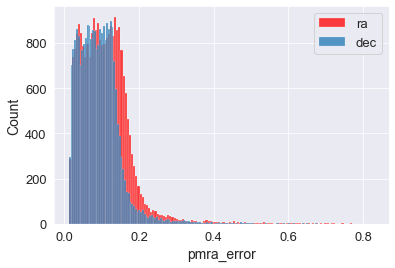

In [40]:
#PM
sn.histplot(data=nf_data['pmra_error'],label='ra',color='r')
#Parallax
sn.histplot(data=nf_data['pmdec_error'],label='dec')
plt.legend()

Make cuts of 0.6 and 0.4

In [41]:
nf_data=nf_data[nf_data['pmra_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['pmdec_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['parallax_error']<=0.2].reset_index(drop=True)

In [42]:
len(nf_data)

21476

# Analysis of the RP

In [43]:
nf_data['phot_rp_mean_flux_error'].max()

20211.973

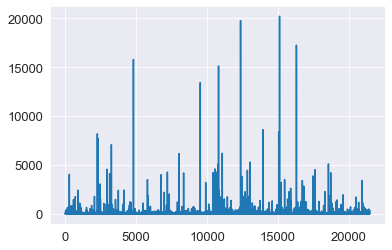

In [44]:
plt.plot(nf_data['phot_rp_mean_flux_error'].values)

In [45]:
nf_data=nf_data[nf_data['phot_rp_mean_flux_error']<1000]

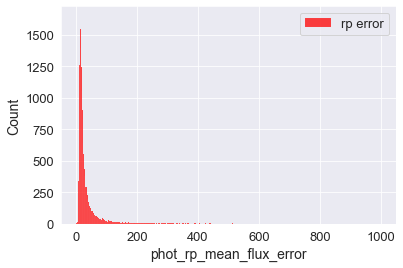

In [46]:
#rp
sn.histplot(data=nf_data['phot_rp_mean_flux_error'],label='rp error',color='r')
#bp
#sn.histplot(data=nf_data['phot_bp_mean_flux_error'],label='bp error')
plt.legend()

# Analysis of the BP

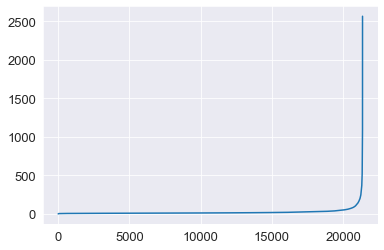

In [47]:
plt.plot(nf_data['phot_bp_mean_flux_error'].sort_values().values)

In [48]:
nf_data=nf_data[nf_data['phot_bp_mean_flux_error']<1000]

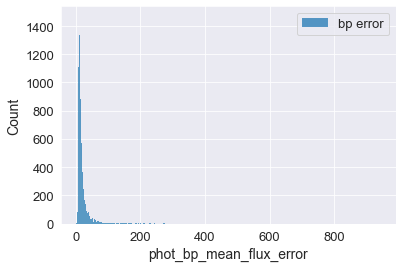

In [49]:
#bp
sn.histplot(data=nf_data['phot_bp_mean_flux_error'],label='bp error')
plt.legend()

# G mag error

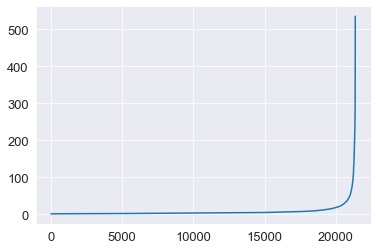

In [50]:
plt.plot(nf_data['phot_g_mean_flux_error'].sort_values().values)

In [51]:
nf_data=nf_data[nf_data['phot_g_mean_flux_error']<1000]

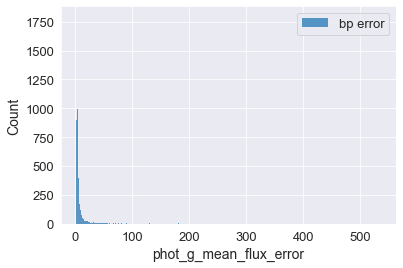

In [52]:
#bp
sn.histplot(data=nf_data['phot_g_mean_flux_error'],label='bp error')
plt.legend()

In [53]:
nf_data=nf_data.reset_index(drop=True)

### RGEO CUT

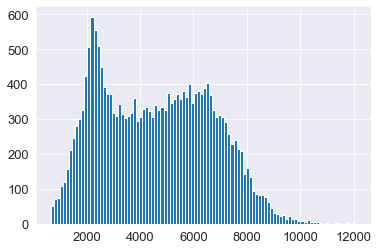

In [54]:
plt.hist(nf_data['rgeo'],bins=100)
plt.show()


Take away eveything bigger than 8kparsec

In [55]:
nf_data=nf_data[nf_data['rgeo']<=8000].reset_index()

### Data preprocessing

In our first attempt we ask the model to learn on noisy astrometric data and see what happens, then compare it to a standard GMM. We will see in our first attempt that the model doesn't perform much differently to that of the standard GMM, in fact it will work slightly better. However on the full dataset the XDGMM is still the best.

In [56]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()
column_names=['pmra', 'pmdec',
       'rgeo','ra','dec']
#column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
#column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec']
column_names=['ra','dec','rgeo','pmra','pmdec','mean_absolute_mag_g_band','bp_rp','bp_g','g_rp']
scaled_data=scaler.fit_transform(nf_data[column_names].values)

# Noramlising Flow Model

In [57]:
len(nf_data)

20381

In [58]:
batch_size = int(len(scaled_data)) #617 #factor for 1090
lr = 1e-3
epochs = 50


In [59]:
# Target distribution means
r = 1.0
means = torch.tensor([[-r for i in range(len(column_names))], [r for i in range(len(column_names))], [(-1)**i*r for i in range(len(column_names))]])


from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


X=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size,drop_last=True) 
model = FlowGMM(layers=5,n_features=scaled_data[0].shape[-1],mixture_components=3,hidden_dims=[50,25],d=3,means=means,unlabelled=0.5)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



TypeError: __init__() got an unexpected keyword argument 'unlabelled'

In [ ]:
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)
            
            optimizer.zero_grad()

            y,gmm,loss,ll,det = model(x)

            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        #print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")


torch.Size([20381])


RuntimeError: running_mean should contain 2 elements not 9

In [ ]:
model.eval()

FlowGMM(
  (s_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=6, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=6, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=6, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=

In [ ]:
import matplotlib.pyplot as plt
for i in range (len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()


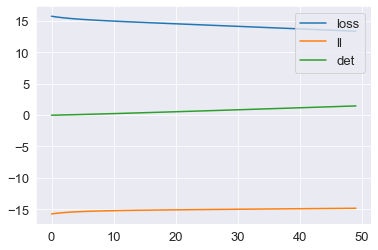

In [ ]:
plt.plot(plot_loss,label='loss')
plt.plot(plotll,label='ll')
plt.plot(plotdet,label='det')
plt.legend()
plt.show()

In [ ]:
y,gmm,loss,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.class_probs(y).detach().numpy()
y=y.detach().numpy()


/Users/mattocallaghan/GES/Data_handling/gmmflow.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


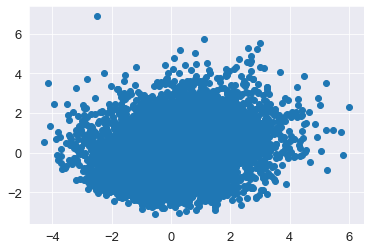

In [ ]:
plt.scatter(y.transpose()[0],y.transpose()[1])

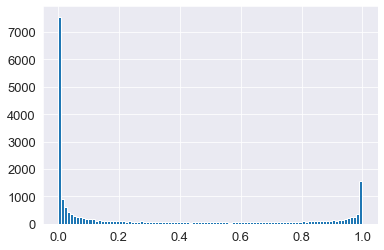

In [ ]:
j=0
plt.hist(probs.transpose()[j],bins=100)
plt.show()

In [ ]:
column=[i for i in range(probs.shape[-1])]
df=pd.DataFrame(data=probs,columns=column)
plotdf=pd.concat([nf_data,df],axis=1)

In [ ]:
plotdf

,index,ra,dec,parallax,VRAD,pmra,pmdec,bp_g,g_rp,ra_error,...,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,rgeo,0,1,2
0,0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,0.590866,0.740053,0.062462,...,3.267539,12.032261,13.133354,1077.94260,123.19489,223.189440,1942.98157,4.628283e-01,0.003138,5.340336e-01
1,1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,0.413675,1.044496,0.116390,...,2.765547,20.419193,49.949870,511.61658,34.33107,31.203371,6141.48389,3.426083e-01,0.527462,1.299301e-01
2,2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,0.575531,0.677193,0.061189,...,2.765688,8.391808,11.373121,1197.15140,168.40495,228.644740,2671.46338,9.793156e-01,0.000023,2.066131e-02
3,3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,0.585712,0.756983,0.043225,...,3.499412,15.342039,11.257838,1742.58020,168.06972,457.864930,1887.64343,9.883575e-01,0.001688,9.954833e-03
4,4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,0.529069,0.704749,0.036199,...,3.845628,9.647141,11.867042,2172.79220,385.85970,567.223450,2360.14062,9.601846e-01,0.000635,3.918037e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,21358,282.786788,-6.009368,0.532015,0.00,-1.428502,-3.934359,0.751892,0.909428,0.111580,...,2.969565,7.484189,17.340998,634.09480,91.28843,105.622154,2439.45557,5.553211e-05,0.998354,1.590450e-03
20377,21359,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,0.790930,0.894377,0.082114,...,3.961165,9.669498,12.439868,589.08026,84.46786,179.946430,7084.01074,3.059384e-04,0.989406,1.028828e-02
20378,21360,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.720057,0.885668,0.057465,...,3.325069,8.880351,16.920698,1381.98470,193.33986,258.442700,2100.93555,9.796882e-09,0.999995,5.268624e-06
20379,21361,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,1.733685,1.229452,0.071895,...,2.894869,6.128861,10.157309,994.19196,68.97879,370.094400,7769.46533,1.116677e-11,1.000000,1.958629e-08


In [ ]:

data_for_hr1_full=plotdf[plotdf[j]>0.90]
data_for_hr2_full=plotdf[plotdf['prob']>0.9]
both_solution=data_for_hr1_full[data_for_hr1_full['prob']>0.9]

data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=0.9]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]<=0.9]

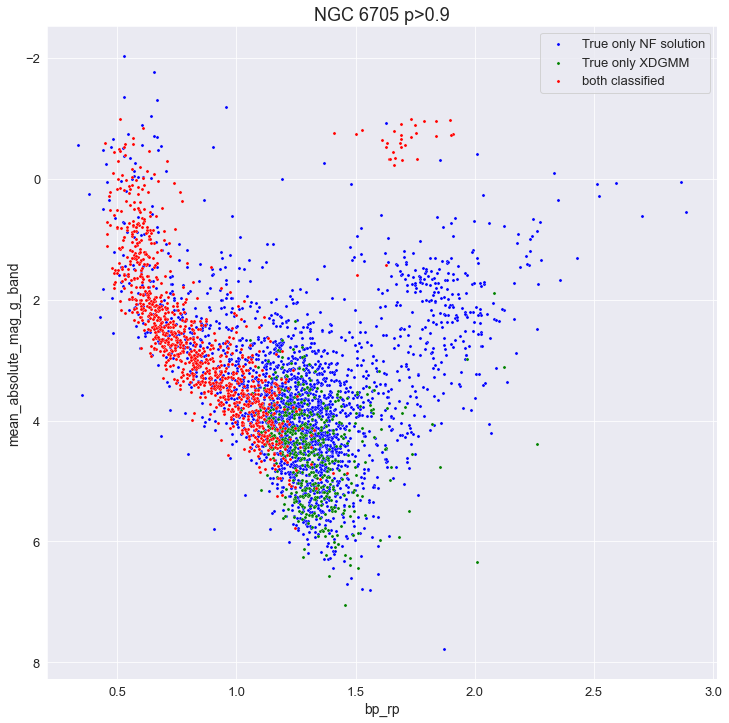

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True only NF solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only XDGMM',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

# Analyse the parameters of this sample

In [ ]:
nf=plotdf[plotdf[j]>0.9]
gmm=plotdf[plotdf['prob']>0.9]

NameError: name 'nf' is not defined

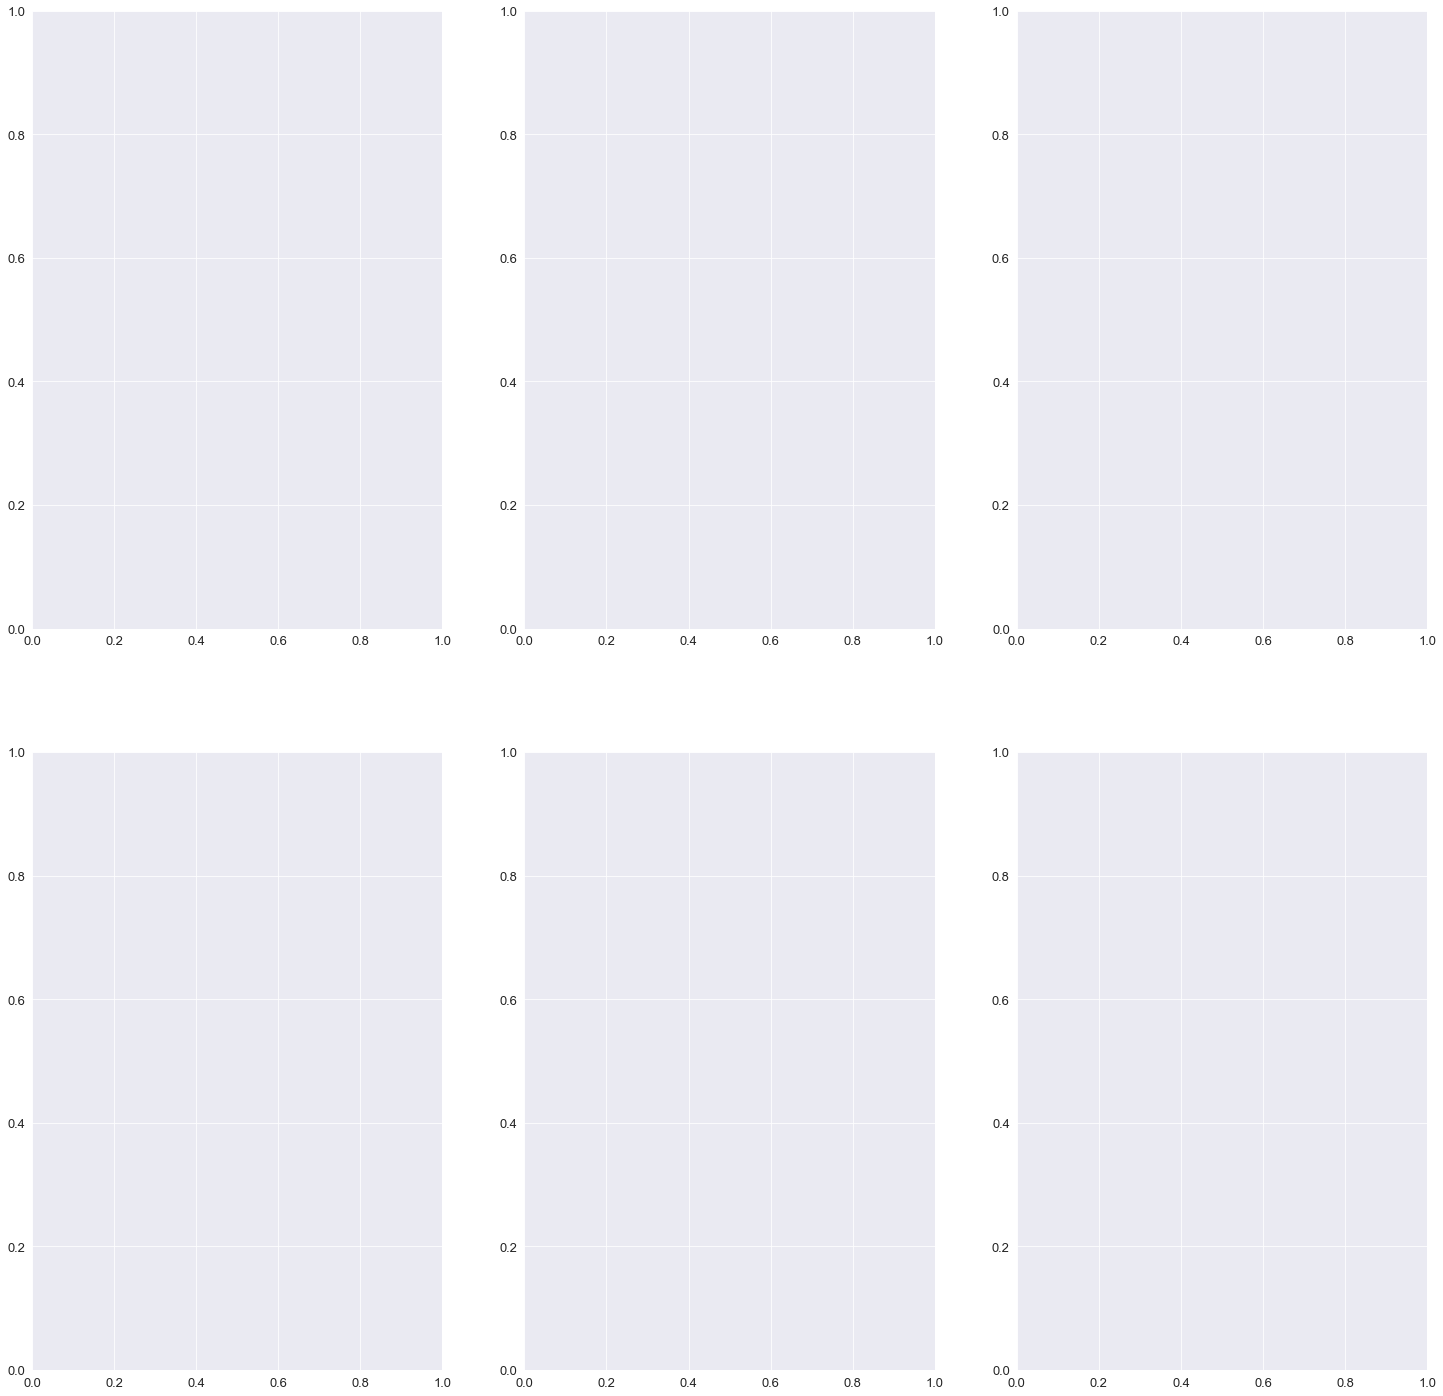

In [ ]:


f, axes = plt.subplots(2, 3)
f.set_figheight(25)
f.set_figwidth(25)

scatter=nf_data
sn.scatterplot(data=nf,x='bp_rp',y='mean_absolute_mag_g_band',hue='rgeo',ax=axes[0,0],label='NF DIST',color='b')

sn.scatterplot(data=gmm,x='bp_rp',y='mean_absolute_mag_g_band',hue='rgeo',ax=axes[0,1],label='XDGMM DIST',color='b')

sn.scatterplot(data=nf,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmra',ax=axes[0,2],label='NF PMRA',color='b')

sn.scatterplot(data=gmm,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmra',ax=axes[1,0],label='GMM PMRA',color='b')
sn.scatterplot(data=nf,x='bp_rp',y='mean_absolute_mag_g_band',hue='parallax',ax=axes[1,1],label='NF parallax',color='b')

sn.scatterplot(data=gmm,x='bp_rp',y='mean_absolute_mag_g_band',hue='parallax',ax=axes[1,2],label='XDGMM parallax',color='b')
#axes.set_xlim(0,2.5)

plt.legend()
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].invert_yaxis()
plt.show()


# Now compare to a standard gaussian mixture model on the scaled data

In [ ]:
gmm=GaussianMixture(n_components=3,n_features=scaled_data.shape[-1],init_params='random')
gmm.fit(torch.tensor(scaled_data).float())

In [ ]:
p=gmm.predict_proba(torch.tensor(scaled_data).float()).detach().numpy()

(array([10585.,  2100.,  1009.,   728.,   518.,   466.,   414.,   418.,
          513.,  3630.]),
 array([6.817893e-12, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

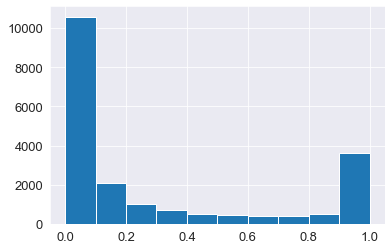

In [ ]:
plt.hist(p.transpose()[0])

In [ ]:
plotdf['proba']=p.transpose()[1]

In [ ]:
data_for_hr1_full=plotdf[plotdf[j]>0.9]
data_for_hr2_full=plotdf[plotdf['proba']>0.9]
both_solution=data_for_hr1_full[data_for_hr1_full['proba']>0.9]
data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['proba']<=0.9]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]<=0.9]

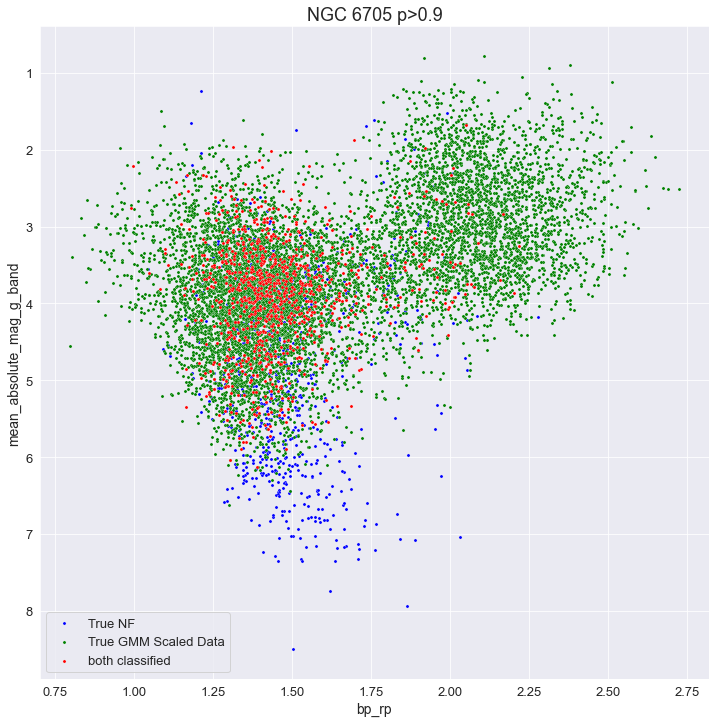

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True NF',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True GMM Scaled Data',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

# Analysis of the components
Cluster component

In [ ]:
cluster1=plotdf[plotdf[2]>0.9]
cluster2=plotdf[plotdf['prob']>0.9]

The normalising flow has more tailed distances

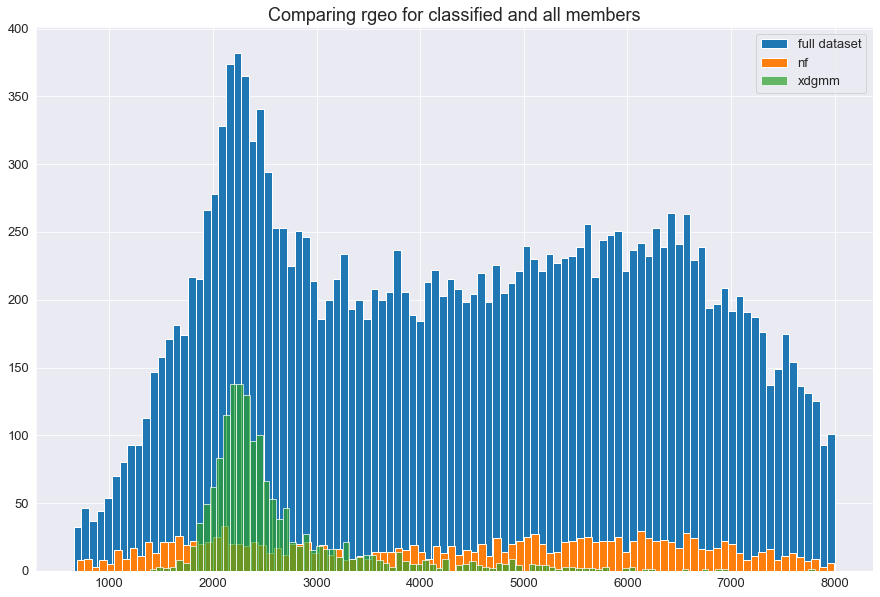

In [ ]:
par='rgeo'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.hist(cluster2[par],bins=100,label='xdgmm',alpha=0.7)
plt.title('Comparing '+par+' for classified and all members')
plt.legend()
plt.show()

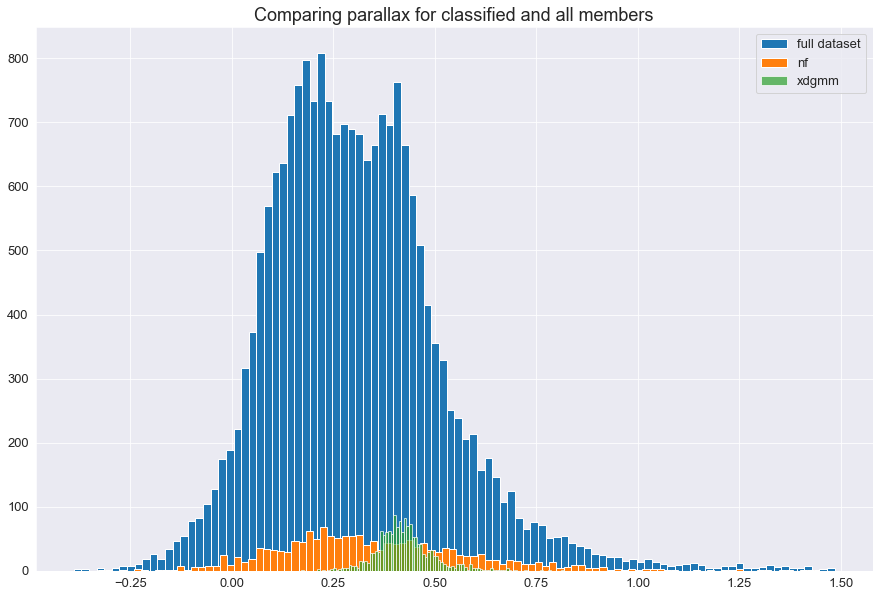

In [ ]:
par='parallax'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.hist(cluster2[par],bins=100,label='xdgmm',alpha=0.7)
plt.title('Comparing '+par+ ' for classified and all members')
plt.legend()
plt.show()

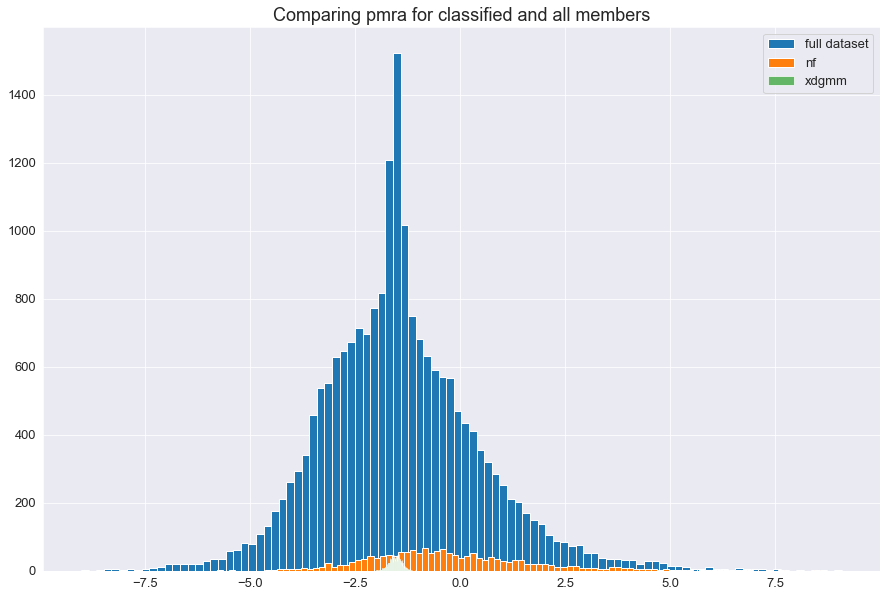

In [ ]:
par='pmra'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.hist(cluster2[par],bins=100,label='xdgmm',alpha=0.7)
plt.title('Comparing '+par+ ' for classified and all members')
plt.legend()
plt.show()

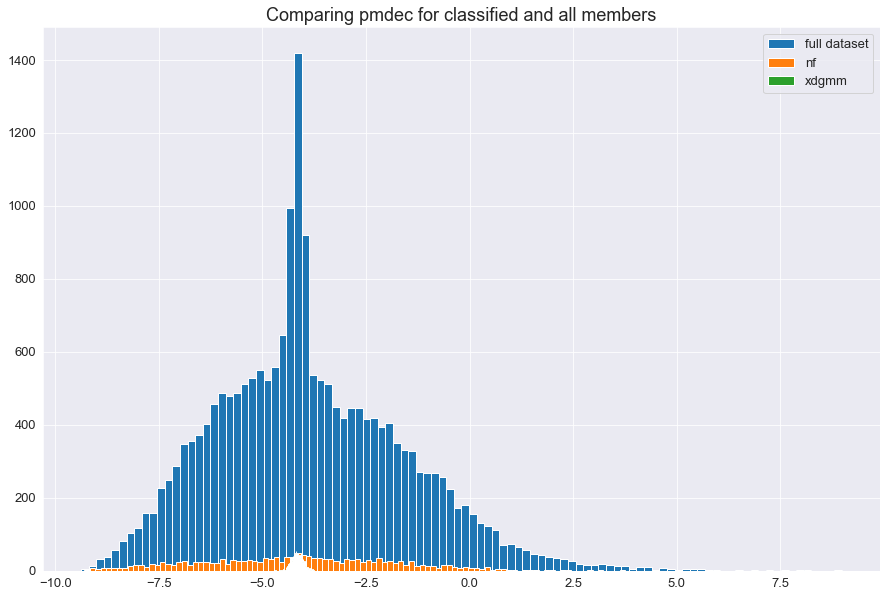

In [ ]:
par='pmdec'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.hist(cluster2[par],bins=100,label='xdgmm')
plt.title('Comparing '+par+ ' for classified and all members')
plt.legend()
plt.show()

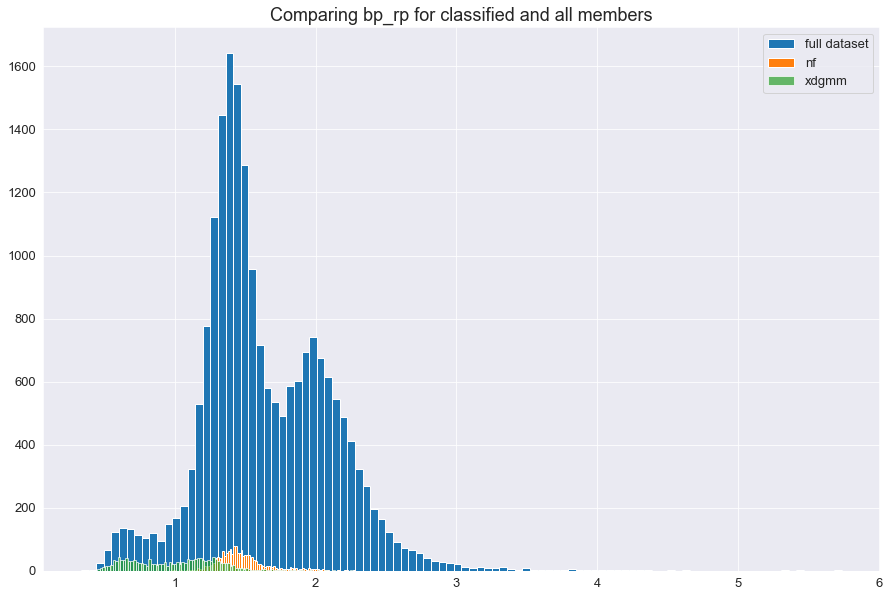

In [ ]:
par='bp_rp'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.hist(cluster2[par],bins=100,label='xdgmm',alpha=0.7)
plt.title('Comparing '+par+ ' for classified and all members')
plt.legend()
plt.show()

Another component

In [ ]:
cluster1=plotdf[plotdf[4]>0.9]


KeyError: 4

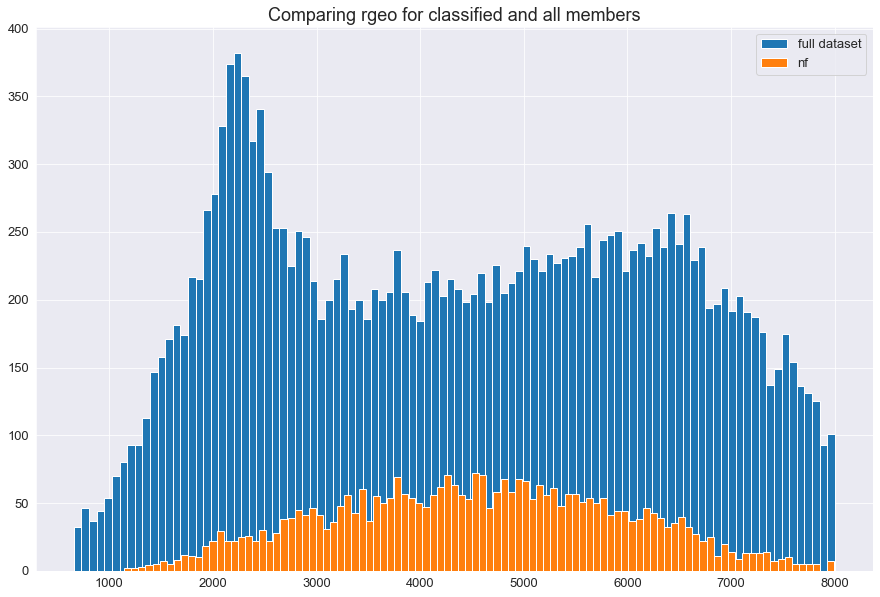

In [ ]:
par='rgeo'
plt.figure(figsize=(15,10))
plt.hist(plotdf[par],bins=100,label='full dataset')
plt.hist(cluster1[par],bins=100,label='nf')
plt.title('Comparing '+par+ ' for classified and all members')
plt.legend()
plt.show()